In [1]:
import message_ix
from message_ix import log
import ixmp as ix
import numpy as np
from scripts_for_diagnostics import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

fs = 18
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True

<IPython.core.display.Javascript object>

In [12]:
mp = ix.Platform('local',jvmargs=["-Xmx8G"])

In [13]:
sc_ref = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500",version=1)
scen_pypsa = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500_PyPSA_Eur")

In [17]:
sc_ref.var("OBJ")

{'lvl': 7016306.5, 'mrg': 0.0}

In [14]:
scen_pypsa.var("OBJ")

{'lvl': 7349981.0, 'mrg': 0.0}

In [4]:
###############################################
case = "new" # in this notebook, we evaluate the new formulation obtained from the softlinkage with PyPSA-Eur
###############################################
scenarios = {"old":sc_ref,
             "new":scen_pypsa}
scen = scenarios[case]
model_years = [x for x in scen.set("year") if x >= scen.firstmodelyear and x <= 2110]
curt_list = [x for x in scen.set("relation") if "curtailment" in x]
technologies = {
    "solar": [x for x in set(scen.set("technology")) if any([y in x for y in ["solar_res"]])], 
    "wind": [x for x in set(scen.set("technology")) if any([y in x for y in ["wind_res", "wind_ref"]])], 
    "wind curtailed": [x for x in set(scen.set("technology")) if "wind_curt" in x],
    "solar curtailed": [x for x in set(scen.set("technology")) if "solar_curt" in x],
    "storage": ["stor_ppl"],
    "export": [x for x in set(scen.set("technology")) if "elec_exp" in x],
    "import": [x for x in set(scen.set("technology")) if "elec_imp" in x],
    "e-mobility": ["elec_trp"],
    "electrolysis": ["h2_elec"],
    "fuel cell": ["h2_fc_I", "h2_fc_RC"],
    "load": ["elec_t_d"],
    }

bins_old = [1,2,3]

In [5]:
vre_list = ["vre_curtailment_w" + str(i) + "s" + str(j) for i in range(1,8) for j in range(1,8)]

# vre relations 
vre_curt_rel = scen.par("relation_activity",
                        {"node_loc": "R11_WEU",
                        "year_rel":2050,
                        "relation":vre_list,}).relation.unique().tolist()

bins = list(pd.Index(vre_curt_rel).str.split("_",expand=True).get_level_values(2))

# Energy and capacity mix 

First, we show the results obtained with the reference scenario with the original VRE representation:

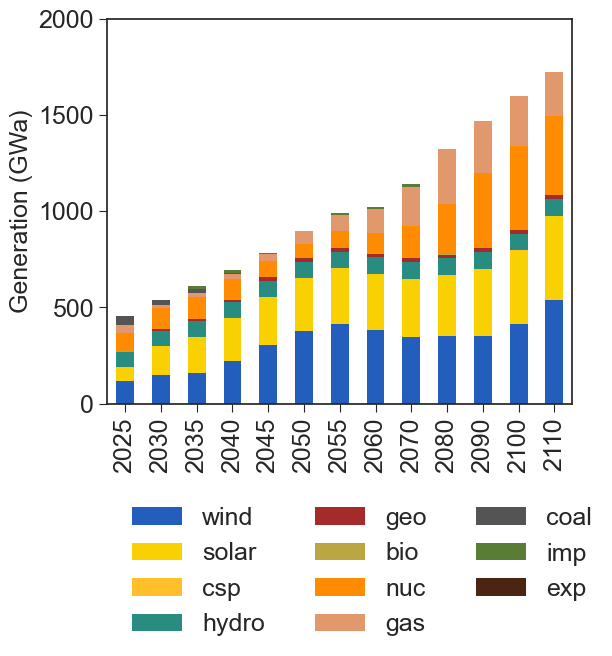

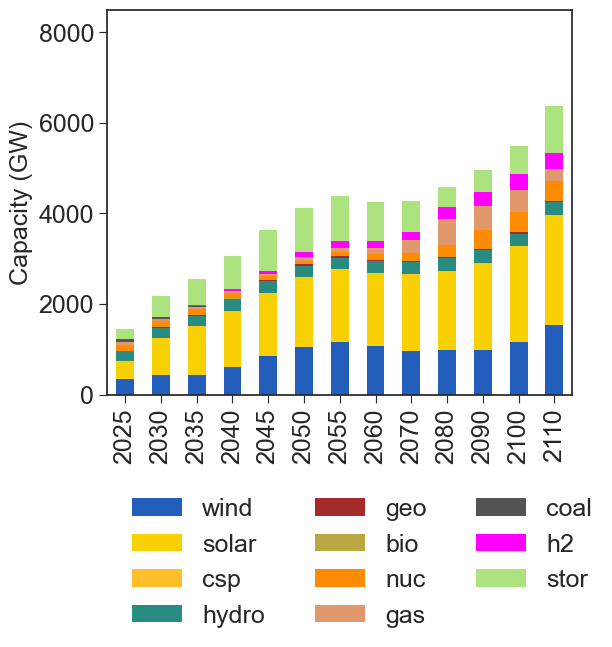

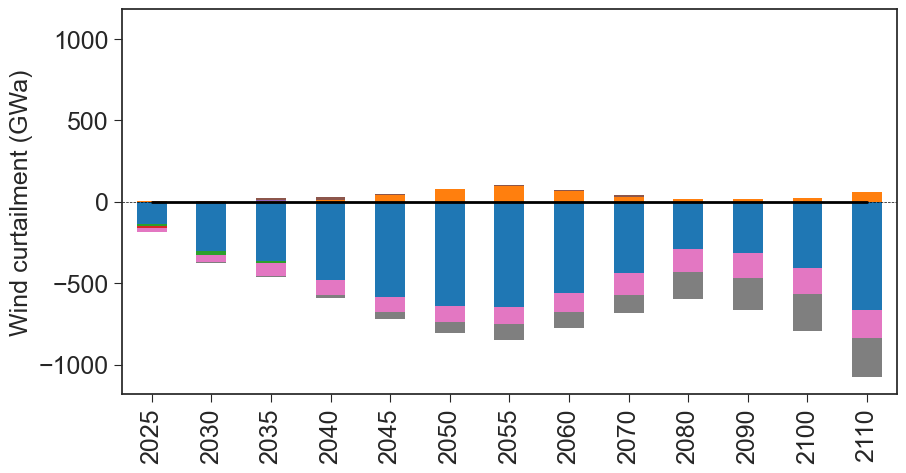

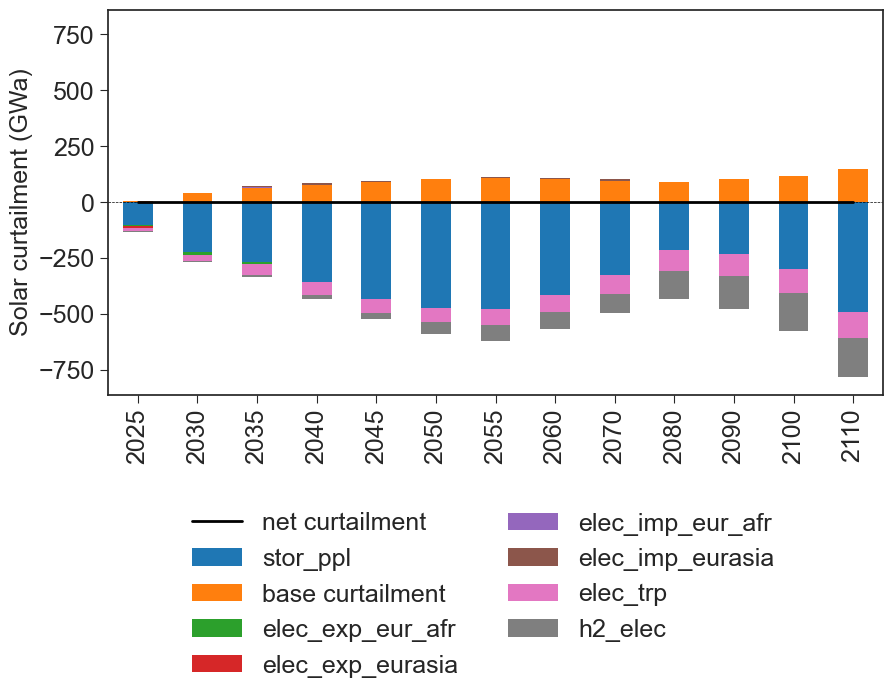

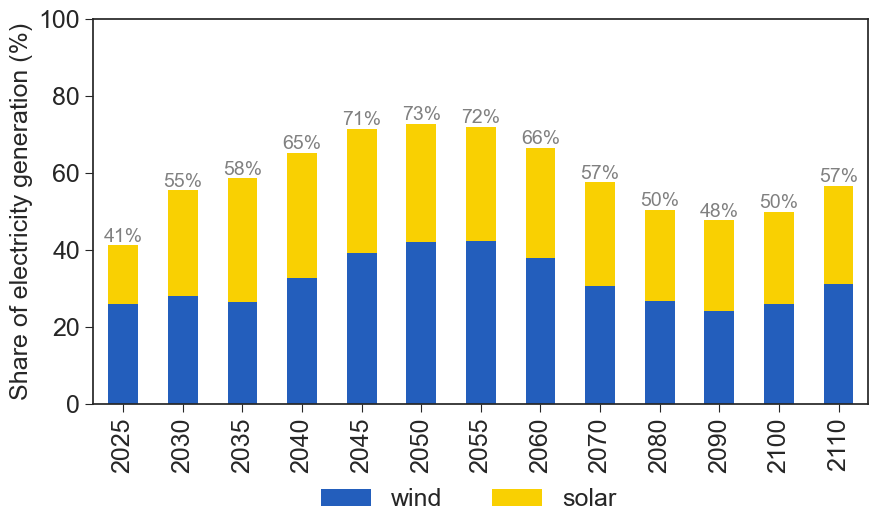

In [18]:
fig1, fig2, fig3, fig4, fig5, df_generation_ref, df_capacity_ref, tech_cap_ref, tech_act_ref, VRE_share_ref = plot_generation_and_capacity(sc_ref, technologies, model_years, bins_old, formulation="old")

Then, we show the results obtained with the PyPSA-Eur softlink:

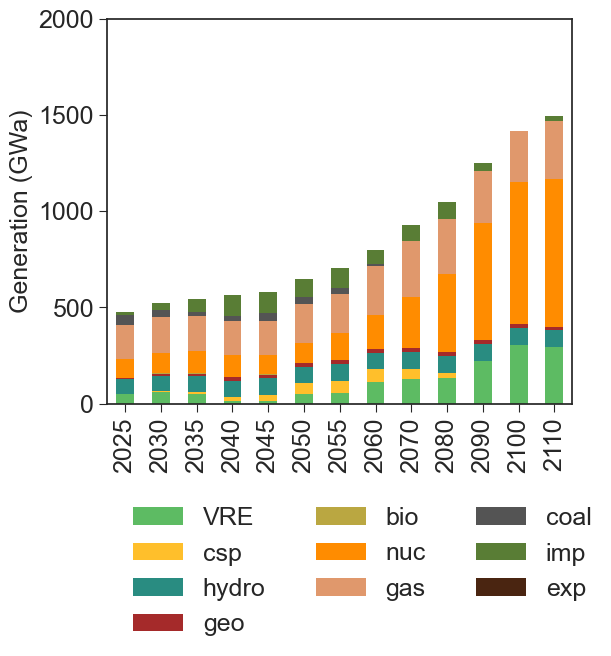

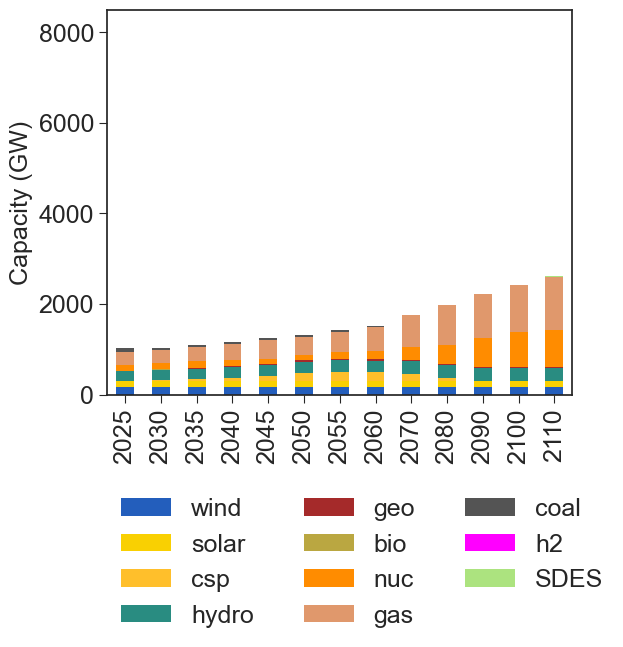

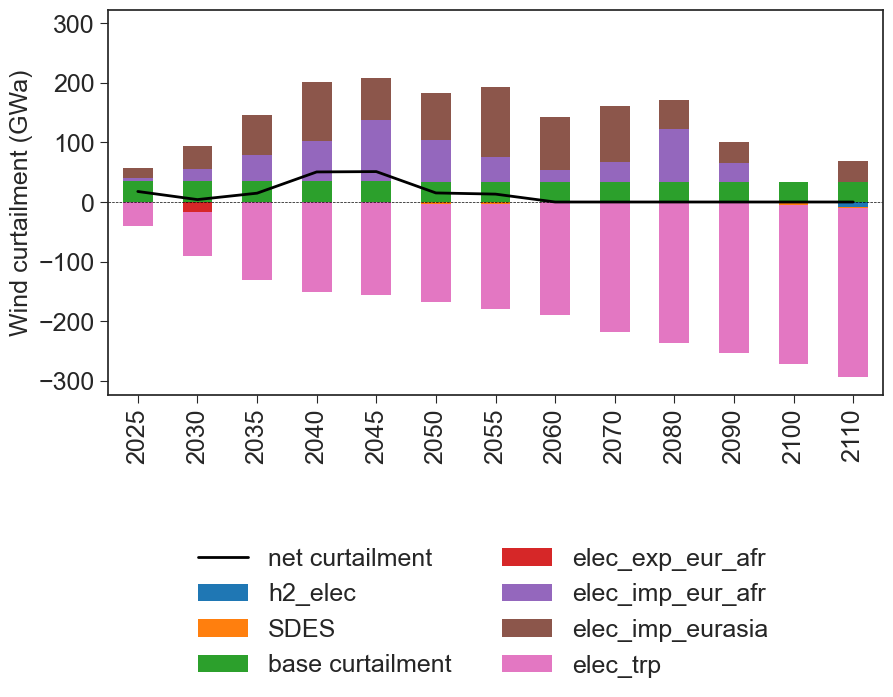

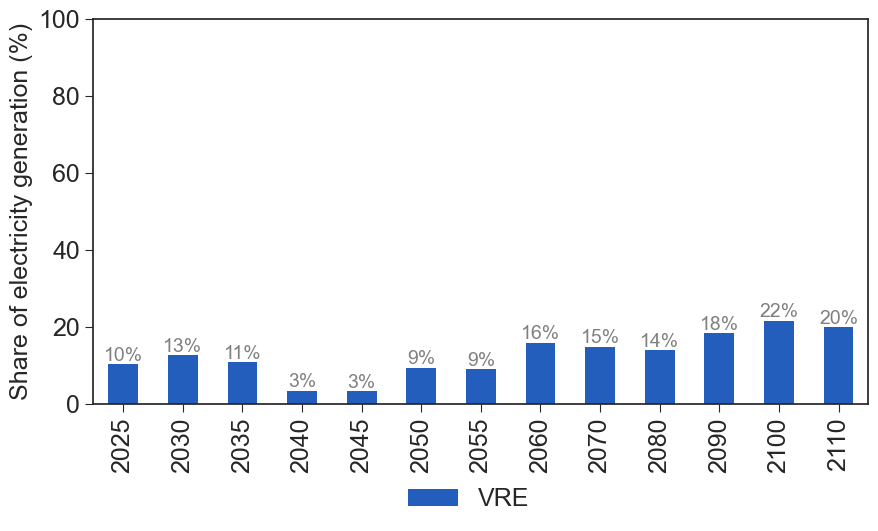

In [7]:
fig1, fig2, fig3, fig4, fig5, df_generation, df_capacity, tech_cap, tech_act, VRE_share = plot_generation_and_capacity(scen, technologies, model_years, bins, formulation="new")

Difference:

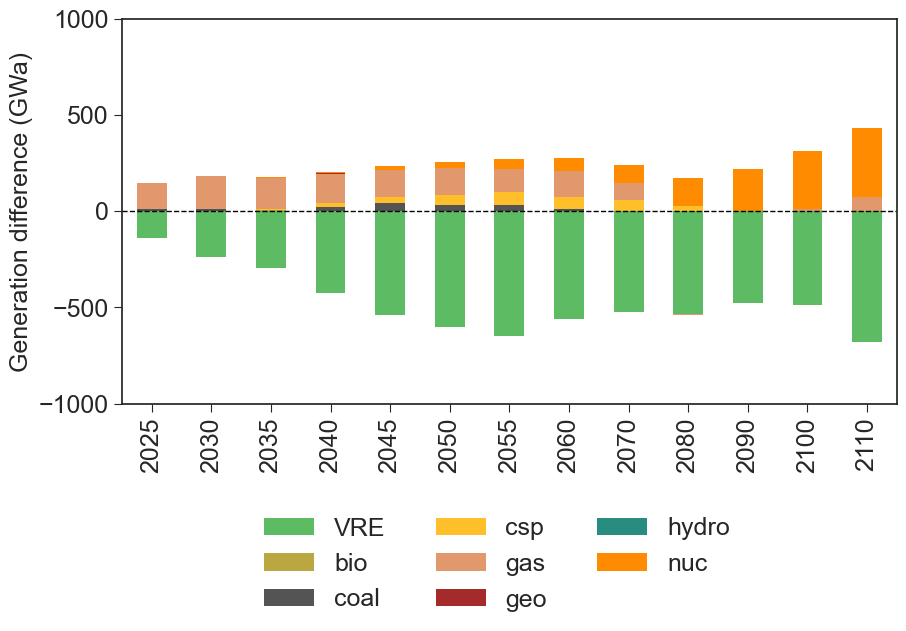

In [8]:
# in df_generation_ref rename wind and solar to VRE
df_generation_ref = df_generation_ref.rename(columns={"wind":"VRE","solar":"VRE"})
# then group by column names
df_generation_ref = df_generation_ref.groupby(df_generation_ref.columns, axis=1).sum()

df_diff = df_generation - df_generation_ref
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-1000,1000)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Generation difference (GWa)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, fontsize=fs)

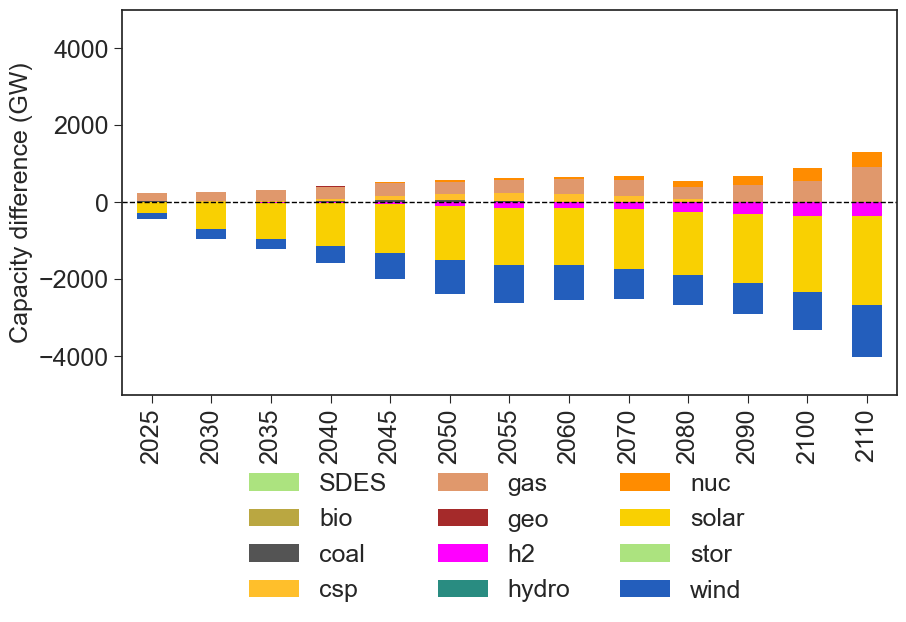

In [9]:
df_diff = (df_capacity - df_capacity_ref)
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-5000,5000)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Capacity difference (GW)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3, fontsize=fs)

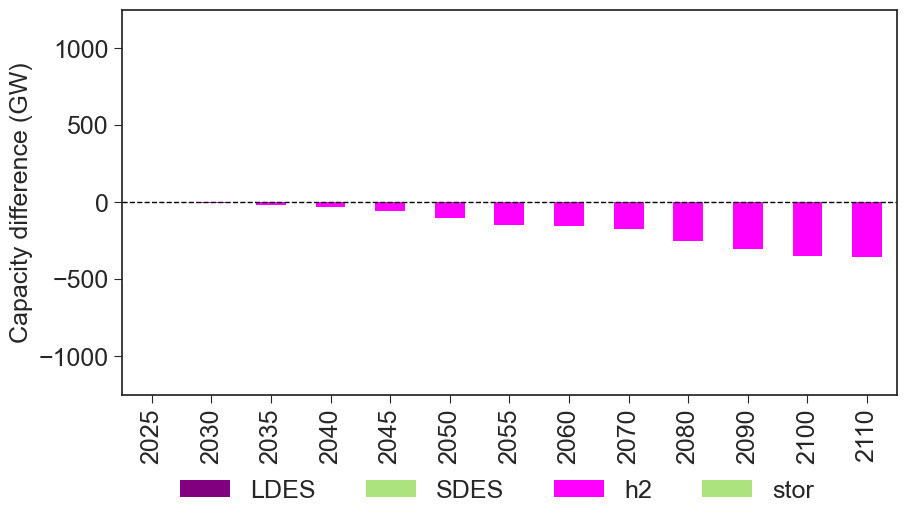

In [10]:
df_diff = (tech_cap - tech_cap_ref)
df_diff = df_diff.unstack().T
df_diff.rename(columns={"h2_elec":"h2","stor_ppl":"stor"},inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
df_diff.plot.bar(stacked=True, ax = ax,
                 color=[colors_dict[i] for i in df_diff.columns])

ax.set_ylabel("")
ax.axhline(0,color="k",ls="--",lw=1)
ax.set_ylim(-1250,1250)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("Capacity difference (GW)")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=fs)

In [11]:
mp.close_db()